In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
from fastai.utils.mem import *
%matplotlib inline

###### Setting the path

In [2]:
path = Path("C:/Users/shahi/.fastai/data/lgg-mri-segmentation/kaggle_3m")

In [3]:
path

WindowsPath('C:/Users/shahi/.fastai/data/lgg-mri-segmentation/kaggle_3m')

In [4]:
getMask = lambda x: x.parents[0] / (x.stem + '_mask' + x.suffix)
tempImgFile = path/"TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif"
tempMaskFile = getMask(tempImgFile)

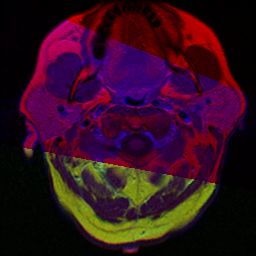

In [5]:
image = open_image(tempImgFile)
image

In [6]:
image.shape

torch.Size([3, 256, 256])

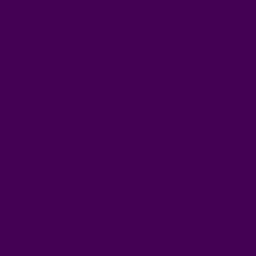

In [7]:
mask = open_mask(getMask(tempImgFile),div=True)
mask

In [8]:

class SegmentationLabelListWithDiv(SegmentationLabelList):
      def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
      _label_cls = SegmentationLabelListWithDiv

In [9]:
codes = [0,1]

In [10]:
np.random.seed(42)
src = (SegmentationItemListWithDiv.from_folder(path)
      .filter_by_func(lambda x:not x.name.endswith('_mask.tif'))
      .split_by_rand_pct(0.2)
      .label_from_func(getMask, classes=codes))


In [11]:
data = (src.transform(get_transforms(),size=256,tfm_y=True)
        .databunch(bs=8,num_workers=0)
        .normalize(imagenet_stats))


In [12]:
data.train_ds

LabelList (3144 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: C:\Users\shahi\.fastai\data\lgg-mri-segmentation\kaggle_3m

In [13]:
data.valid_ds

LabelList (785 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: C:\Users\shahi\.fastai\data\lgg-mri-segmentation\kaggle_3m

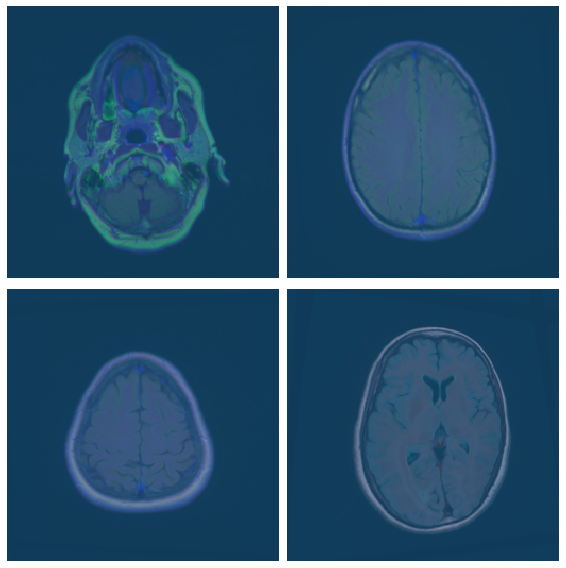

In [14]:
data.show_batch(2)

##### Building the model

#### Pretrained resnet 34 used for downsampling

In [51]:
learn = unet_learner(data,models.resnet34,metrics=[dice])

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


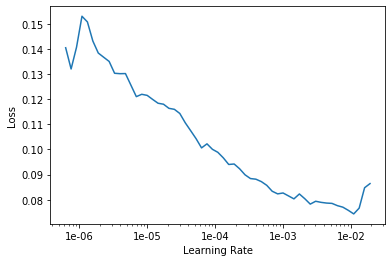

In [49]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(4,1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.020890,0.013998,0.713952,05:02
1,0.013587,0.010203,0.820864,05:03
2,0.009635,0.008074,0.878487,05:05
3,0.008174,0.007584,0.878695,05:01


In [54]:
learn.unfreeze()
learn.fit_one_cycle(4,1e-4,wd=1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.009103,0.007886,0.883912,05:07
1,0.007992,0.008006,0.865498,05:13
2,0.005687,0.005590,0.912123,05:14
3,0.005387,0.005670,0.914316,05:13


#### Resnet 34 without pretrained weights with dialation 

In [55]:
learn.save('ResnetWithPrettrained')

In [59]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

In [15]:
def conv(ni,nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1,dilation=2)

In [16]:
def conv2(ni,nf): return conv_layer(ni,nf)

In [36]:
models.resnet34

<function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>

In [ ]:
model = nn.Sequential(
    conv2(3,8),
    res_block(8),
    conv2(8,16),
    res_block(16),
    conv2(16,32),
    res_block(32),
    

)

In [93]:
act_fn = nn.ReLU(inplace=True)

In [113]:

def presnet(block, n_layers, name, pre=False, **kwargs):
    model = PResNet(block, n_layers, **kwargs)
    #if pre: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    if pre: model.load_state_dict(torch.load(model_urls[name]))
    return model


def presnet18(pretrained=False, **kwargs):
    return presnet(BasicBlock, [2, 2, 2, 2], 'presnet18', pre=pretrained, **kwargs)

In [101]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [28]:
model3 = nn.Sequential(
    conv2(3, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    )

In [25]:
model3

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [26]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [64]:
learn3 = unet_learner(data,drn_d_38,metrics=[dice],pretrained=True)

In [65]:
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


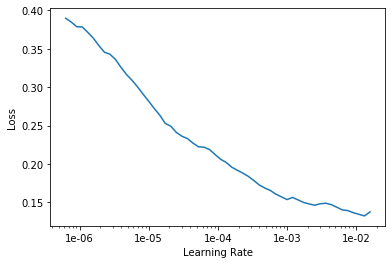

In [66]:
learn3.recorder.plot()

In [67]:
learn3.fit_one_cycle(4,1e-4,wd=1e-1)

epoch,train_loss,valid_loss,dice,time
0,0.026923,0.021736,0.709862,07:31
1,0.017793,0.015974,0.784858,08:04
2,0.017845,0.013492,0.807605,08:10
3,0.012288,0.012829,0.820899,07:45


In [68]:
learn3.unfreeze()
learn3.fit_one_cycle(4,1e-4,wd=1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.014880,0.011465,0.821104,08:15
1,0.010526,0.007729,0.888197,08:44
2,0.006720,0.006262,0.909797,08:41
3,0.005676,0.005622,0.913522,08:40


In [69]:
learn3.save('ResnetWithPretrainedDilation')

In [70]:
learn3.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 256, 256]       2,352      True      
______________________________________________________________________
BatchNorm2d          [16, 256, 256]       32         True      
______________________________________________________________________
ReLU                 [16, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [16, 256, 256]       2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 256, 256]       32         True      
______________________________________________________________________
ReLU                 [16, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [32, 128, 128]       4,608      True      
__________________________________________________

In [59]:
import pdb

import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

BatchNorm = nn.BatchNorm2d


# __all__ = ['DRN', 'drn26', 'drn42', 'drn58']


webroot = 'http://dl.yf.io/drn/'

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'drn-c-26': webroot + 'drn_c_26-ddedf421.pth',
    'drn-c-42': webroot + 'drn_c_42-9d336e8c.pth',
    'drn-c-58': webroot + 'drn_c_58-0a53a92c.pth',
    'drn-d-22': webroot + 'drn_d_22-4bd2f8ea.pth',
    'drn-d-38': webroot + 'drn_d_38-eebb45f0.pth',
    'drn-d-54': webroot + 'drn_d_54-0e0534ff.pth',
    'drn-d-105': webroot + 'drn_d_105-12b40979.pth'
}


def conv3x3(in_planes, out_planes, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride,
                             padding=dilation[0], dilation=dilation[0])
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,
                             padding=dilation[1], dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.downsample = downsample
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        if self.residual:
            out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation[1], bias=False,
                               dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class DRN(nn.Module):

    def __init__(self, block, layers, num_classes=1000,
                 channels=(16, 32, 64, 128, 256, 512, 512, 512),
                 out_map=False, out_middle=False, pool_size=28, arch='D'):
        super(DRN, self).__init__()
        self.inplanes = channels[0]
        self.out_map = out_map
        self.out_dim = channels[-1]
        self.out_middle = out_middle
        self.arch = arch

        if arch == 'C':
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                                   padding=3, bias=False)
            self.bn1 = BatchNorm(channels[0])
            self.relu = nn.ReLU(inplace=True)

            self.layer1 = self._make_layer(
                BasicBlock, channels[0], layers[0], stride=1)
            self.layer2 = self._make_layer(
                BasicBlock, channels[1], layers[1], stride=2)
        elif arch == 'D':
            self.layer0 = nn.Sequential(
                nn.Conv2d(3, channels[0], kernel_size=7, stride=1, padding=3,
                          bias=False),
                BatchNorm(channels[0]),
                nn.ReLU(inplace=True)
            )

            self.layer1 = self._make_conv_layers(
                channels[0], layers[0], stride=1)
            self.layer2 = self._make_conv_layers(
                channels[1], layers[1], stride=2)

        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2)
        self.layer5 = self._make_layer(block, channels[4], layers[4],
                                       dilation=2, new_level=False)
        self.layer6 = None if layers[5] == 0 else \
            self._make_layer(block, channels[5], layers[5], dilation=4,
                             new_level=False)

        if arch == 'C':
            self.layer7 = None if layers[6] == 0 else \
                self._make_layer(BasicBlock, channels[6], layers[6], dilation=2,
                                 new_level=False, residual=False)
            self.layer8 = None if layers[7] == 0 else \
                self._make_layer(BasicBlock, channels[7], layers[7], dilation=1,
                                 new_level=False, residual=False)
        elif arch == 'D':
            self.layer7 = None if layers[6] == 0 else \
                self._make_conv_layers(channels[6], layers[6], dilation=2)
            self.layer8 = None if layers[7] == 0 else \
                self._make_conv_layers(channels[7], layers[7], dilation=1)

        if num_classes > 0:
            self.avgpool = nn.AvgPool2d(pool_size)
            self.fc = nn.Conv2d(self.out_dim, num_classes, kernel_size=1,
                                stride=1, padding=0, bias=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1,
                    new_level=True, residual=True):
        assert dilation == 1 or dilation % 2 == 0
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = list()
        layers.append(block(
            self.inplanes, planes, stride, downsample,
            dilation=(1, 1) if dilation == 1 else (
                dilation // 2 if new_level else dilation, dilation),
            residual=residual))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, residual=residual,
                                dilation=(dilation, dilation)))

        return nn.Sequential(*layers)

    def _make_conv_layers(self, channels, convs, stride=1, dilation=1):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(self.inplanes, channels, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                BatchNorm(channels),
                nn.ReLU(inplace=True)])
            self.inplanes = channels
        return nn.Sequential(*modules)

    def forward(self, x):
        y = list()

        if self.arch == 'C':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        elif self.arch == 'D':
            x = self.layer0(x)

        x = self.layer1(x)
        y.append(x)
        x = self.layer2(x)
        y.append(x)

        x = self.layer3(x)
        y.append(x)

        x = self.layer4(x)
        y.append(x)

        x = self.layer5(x)
        y.append(x)

        if self.layer6 is not None:
            x = self.layer6(x)
            y.append(x)

        if self.layer7 is not None:
            x = self.layer7(x)
            y.append(x)

        if self.layer8 is not None:
            x = self.layer8(x)
            y.append(x)

        if self.out_map:
            x = self.fc(x)
        else:
            x = self.avgpool(x)
            x = self.fc(x)
            x = x.view(x.size(0), -1)

        if self.out_middle:
            return x, y
        else:
            return x


class DRN_A(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(DRN_A, self).__init__()
        self.out_dim = 512 * block.expansion
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                       dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                       dilation=4)
        self.avgpool = nn.AvgPool2d(28, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, nn.BatchNorm2d):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                dilation=(dilation, dilation)))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def drn_a_50(pretrained=False, **kwargs):
    model = DRN_A(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def drn_c_26(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-26']))
    return model


def drn_c_42(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-42']))
    return model


def drn_c_58(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-58']))
    return model


def drn_d_22(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-22']))
    return model


def drn_d_24(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-24']))
    return model


def drn_d_38(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-38']))
    return model


def drn_d_40(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-40']))
    return model


def drn_d_54(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-54']))
    return model


def drn_d_56(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-56']))
    return model


def drn_d_105(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-105']))
    return model


def drn_d_107(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-107']))
    return model

In [57]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1,padding=1,dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False,dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,dilation=(1,1)):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride,padding=dilation[0],dilation=dilation[1])
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,padding=dilation[1],dilation=dilation[1])
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,dilation=(1,1)):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model
